In [101]:
import pandas as pd
from IPython.display import Markdown
import prompts
import utils
import json
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
reload(utils)

<module 'utils' from '/usr/local/google/home/raulramos/projects/llmrouting/utils.py'>

In [2]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [58]:
d = pd.read_hdf('dolly_15k_extended_small_3k.h5')

metrics = ['groundness', 'summarization', 'text_quality', 'verbosity']
metrics = {k: pd.read_hdf(f'dolly_15k_extended_small_3k_{k}.h5') for k in metrics}
for z in metrics.values():
    z.set_index('id', inplace=True)

In [84]:
di = d.sample(1).iloc[0]
di

instruction                                           Given a reference text about Justice League Da...
context                                               Justice League Dark is a 2017 American adult a...
response                                              The main actors in Justice League Dark were Ma...
category                                                                                      closed_qa
gemini-2.5-flash-preview-05-20::response              According to the text, the main actors and the...
gemini-2.5-flash-preview-05-20::code                                                                 ok
meta/llama-4-scout-17b-16e-instruct-maas::response    According to the text, the main actors and the...
meta/llama-4-scout-17b-16e-instruct-maas::code                                                       ok
text_embeddings                                       [-0.015762068331241608, 0.0003354823566041887,...
cluster                                                         

In [85]:
print  ('category', di.category, 'cluster', di.cluster)
Markdown(f'{di.context}\n\n----\n\n{di.instruction}')

category closed_qa cluster 2


Justice League Dark is a 2017 American adult animated science fantasy superhero film produced by Warner Bros. Animation and distributed by Warner Home Video. Featuring the DC Comics team of the same name created by Peter Milligan and Mikel Janín, the film is the 27th of the DC Universe Animated Original Movies and the eighth of the DC Animated Movie Universe. Unlike most installments in the DC Animated Universe Movies series, Justice League Dark features an original premise. The film stars Matt Ryan as John Constantine and Jason O'Mara as Batman, reprising their respective roles from previous media. It was released on Digital HD on January 24, 2017, and on DVD and Blu-ray on February 7.

A sequel, Justice League Dark: Apokolips War, was released in May 2020.

----

Given a reference text about Justice League Dark, tell me who the main actors are and what roles they played.

In [86]:
Markdown(di['gemini-2.5-flash-preview-05-20::response'])

According to the text, the main actors and their roles are:

*   **Matt Ryan** as John Constantine
*   **Jason O'Mara** as Batman

In [87]:
Markdown(di['meta/llama-4-scout-17b-16e-instruct-maas::response'])

According to the text, the main actors and their roles are:

1. Matt Ryan - John Constantine
2. Jason O'Mara - Batman

In [88]:
ratings = {k: utils.extract_json_rating(v.loc[di.name].response)for k,v in metrics.items()}
ratings

{'groundness': 0, 'summarization': 0, 'text_quality': 0, 'verbosity': 0}

In [4]:
n_classes = len(np.unique(d.category.values))
c = KMeans(n_clusters=n_classes).fit_predict(list(d.text_embeddings.values))
r = pd.crosstab(d.category.values, c)
r.columns.name = 'clusters'
r.index.name = 'topics'
r

clusters,0,1,2,3,4,5,6,7
topics,,,,,,,,
brainstorming,27,237,1,17,9,22,6,41
classification,4,10,0,10,319,14,1,42
closed_qa,7,1,254,2,1,10,92,1
creative_writing,4,119,0,10,5,3,3,1
general_qa,2,229,0,102,12,33,7,52
information_extraction,120,0,122,1,3,6,60,1
open_qa,8,111,4,203,3,78,1,321
summarization,27,0,126,2,0,7,85,1


## save clusters

In [5]:
d['cluster'] = c
#d.to_hdf('dolly_15k_extended_small_3k.h5', key='main')

In [9]:
d = pd.read_hdf('dolly_15k_extended_small_3k.h5')

In [11]:
r = pd.crosstab(d.category.values, d.cluster.values)
r.columns.name = 'clusters'
r.index.name = 'topics'
r

clusters,0,1,2,3,4,5,6,7
topics,,,,,,,,
brainstorming,0,31,0,266,50,2,11,0
classification,0,4,0,21,42,1,273,59
closed_qa,104,6,92,4,1,160,0,1
creative_writing,0,12,0,126,1,1,5,0
general_qa,3,3,0,350,65,3,12,1
information_extraction,55,110,53,0,1,92,2,0
open_qa,8,9,5,313,387,3,3,1
summarization,72,22,67,1,1,85,0,0


## inspect cluster elements

In [10]:
topic = 'brainstorming'
cluster = 3
d[(c==cluster)&(d.category==topic)].sample(1).instruction.values[0]

'How can a technical expert identify a business use case?'

In [7]:
topic = 'creative_writing'
cluster = 3
d[(c==cluster)&(d.category==topic)].sample(1).instruction.values[0]

'What is a dam?'

In [12]:
topic = 'general_qa'
cluster = 3
d[(c==cluster)&(d.category==topic)].sample(1).instruction.values[0]

'How can I ensure exactly-once delivery when reading data from Kafka with Spark?'

## inspect cluster elements

In [14]:
topic = 'information_extraction'
cluster = 2
d[(c==cluster)&(d.category==topic)].sample(1).instruction.values[0]

'Who is Pearl Jam?'

In [8]:
topic = 'classification'
cluster = 6
d[(c==cluster)&(d.category==topic)].sample(1).instruction.values[0]

'When talking about paint colours, which one of these colours is considered "cold", "warm" or "both". Both meaning the way the colour is perceived depends on the colours surrounding it.\nYellow, Yellow-Orange, Orange, Red-Orange, Red, Red-Violet, Violet, Blue-Violet, Blue, Blue-Green, Green, Yellow-Green'

## tsne

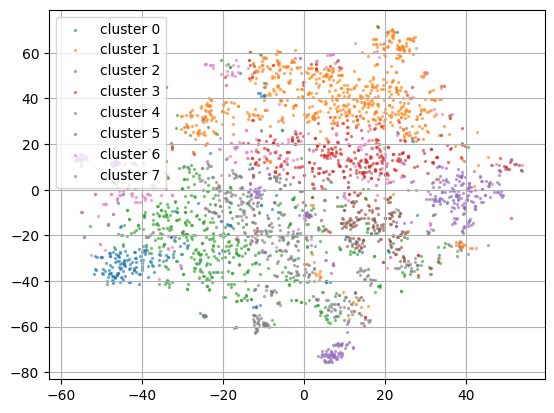

In [103]:
from sklearn.manifold import TSNE

embs = np.r_[[i for i in d.text_embeddings.values]]

embs_tsne = TSNE().fit_transform(embs)
for i in range(8):
    _x = embs_tsne[c==i]
    plt.scatter(_x[:,0], _x[:,1], s=2, alpha=.5, label=f'cluster {i}')
plt.grid()
plt.legend();

In [98]:
np.r_[[i for i in d.text_embeddings.values]]

array([[-2.27317493e-03, -5.44604845e-03, -9.82803293e-03, ...,
         7.47253327e-03,  9.61031008e-04,  1.16733555e-03],
       [-4.21636887e-02, -8.36988329e-04, -9.23765451e-03, ...,
         1.33390650e-02, -9.71433427e-03,  4.42743720e-03],
       [-8.82662274e-03, -1.75403699e-03,  3.13712396e-02, ...,
        -3.17092077e-03, -1.03487531e-02,  8.28544071e-05],
       ...,
       [-1.61642693e-02,  1.73356086e-02, -2.61766580e-03, ...,
         3.20649310e-03, -2.28938032e-02,  8.90259352e-03],
       [-1.90008804e-02, -8.01130757e-03,  1.05943186e-02, ...,
         1.16941822e-03,  9.32761410e-04,  9.67018120e-03],
       [-2.59532072e-02, -2.68954597e-03,  6.93446677e-03, ...,
        -1.44321541e-03, -1.10145863e-02,  5.55745093e-03]])